# Model Explainability Analysis
## Understanding Stock Return Predictions with SHAP and Feature Analysis

This notebook explains why the LightGBM model makes specific predictions by:
1. Analyzing feature importance
2. Using SHAP values to explain individual predictions
3. Comparing top vs bottom predicted stocks
4. Visualizing feature contributions

In [2]:
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 5.9 MB/s  0:00:00

   ------------- -------------------------- 1/3 [cloudpickle]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   ---------------------------------------- 3/3 [shap]



## 1. Load Model and Data

In [3]:
# Load the trained model
model = joblib.load('data5_model.pkl')
print(f"Model loaded: {type(model).__name__}")
print(f"Number of estimators: {model.n_estimators}")

# Load current predictions and features
df = pd.read_excel('data5_current.xlsx')
print(f"\nData shape: {df.shape}")
print(f"Week: {df['week'].iloc[0]}")
print(f"Number of stocks: {len(df)}")

Model loaded: LGBMRegressor
Number of estimators: 100

Data shape: (2642, 19)
Week: 2025-48
Number of stocks: 2642


In [4]:
# Display summary statistics
print("\nPrediction Distribution:")
print(df['predict'].describe())

# Show top 10 predictions
print("\nTop 10 Predicted Stocks:")
print(df[['ticker', 'predict', 'sector', 'size', 'momentum', 'pb', 'roe']].head(10))


Prediction Distribution:
count    2642.000000
mean        0.000551
std         0.010309
min        -0.136996
25%        -0.000380
50%        -0.000179
75%         0.000903
max         0.156814
Name: predict, dtype: float64

Top 10 Predicted Stocks:
  ticker   predict              sector       size  momentum   pb    roe
0    IMA  0.156814          Healthcare  Micro-Cap   -0.6146  0.6 -0.353
1    CKX  0.148191              Energy  Micro-Cap   -0.1189  1.1  0.014
2   SMLR  0.141416          Healthcare  Small-Cap   -0.5798  0.6  0.346
3   MOVE  0.113689          Healthcare  Micro-Cap   -0.8771 -5.2 -2.884
4   LYEL  0.078762          Healthcare  Small-Cap   -0.0668  1.2 -0.659
5   ZBAI  0.075600  Financial Services   Nano-Cap   -0.2846  0.8 -2.033
6   CRBP  0.059136          Healthcare  Small-Cap   -0.0527  2.3 -0.312
7   TENX  0.057048          Healthcare  Micro-Cap    0.3787  0.5 -0.334
8   GDYN  0.053994          Technology  Small-Cap   -0.5623  1.4  0.010
9   FBRX  0.047275          He

## 2. Prepare Features for Analysis

The model was trained on percentile-ranked features. We need to convert the raw features to the same percentile ranks used during training.

In [5]:
# Identify feature columns (exclude ticker, week, return, and categorical columns)
exclude_cols = ['ticker', 'week', 'return', 'predict', 'sector', 'industry', 'size', 'close']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Features used by model ({len(feature_cols)}):")
print(feature_cols)

# Create a copy with raw features for reference
df_raw_features = df[feature_cols].copy()

# Convert to percentile ranks (as done in training)
df_ranked = df.copy()
for col in feature_cols:
    df_ranked[col] = df[col].rank(pct=True)

# Extract feature matrix for SHAP
X = df_ranked[feature_cols].values
print(f"\nFeature matrix shape: {X.shape}")

Features used by model (11):
['momentum', 'lag_week', 'lag_month', 'marketcap', 'pb', 'asset_growth', 'roe', 'gp_to_assets', 'grossmargin', 'assetturnover', 'leverage']

Feature matrix shape: (2642, 11)


## 3. Feature Importance Analysis

First, let's see which features the model considers most important overall.

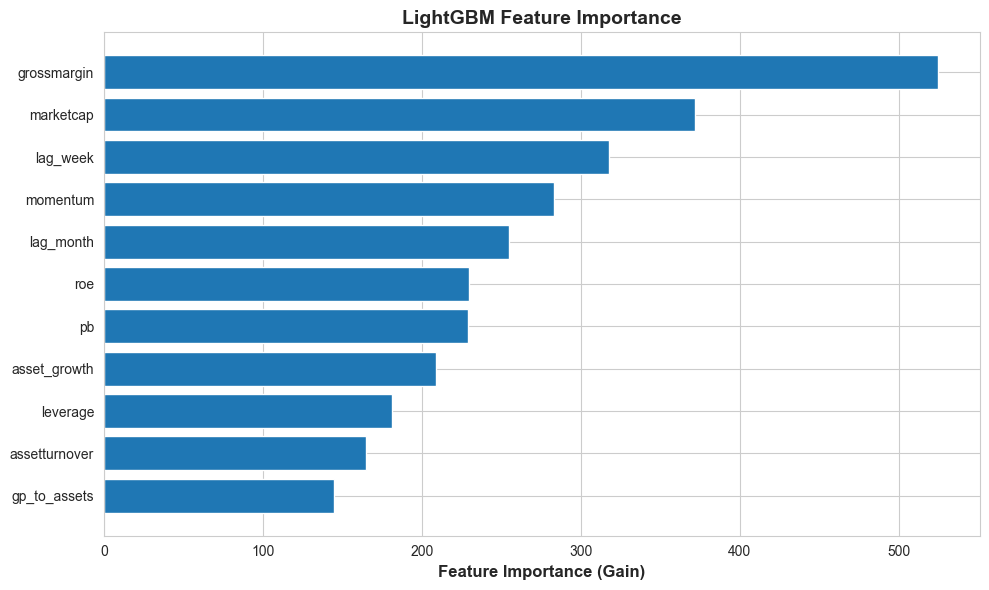


Top 5 Most Important Features:
       feature  importance
8  grossmargin         525
3    marketcap         372
1     lag_week         318
0     momentum         283
2    lag_month         255


In [6]:
# Get feature importance from the model
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Feature Importance (Gain)', fontsize=12, fontweight='bold')
plt.title('LightGBM Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(importance.head())

## 4. SHAP Analysis - Overall Feature Impact

SHAP (SHapley Additive exPlanations) values show how each feature contributes to individual predictions.

In [7]:
# Create SHAP explainer
print("Creating SHAP explainer (this may take a minute)...")
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for all predictions
# For large datasets, we might sample to speed up
sample_size = min(500, len(df))
sample_indices = np.random.choice(len(df), sample_size, replace=False)
X_sample = X[sample_indices]

print(f"Calculating SHAP values for {sample_size} stocks...")
shap_values = explainer.shap_values(X_sample)
print("Done!")

Creating SHAP explainer (this may take a minute)...
Calculating SHAP values for 500 stocks...
Done!


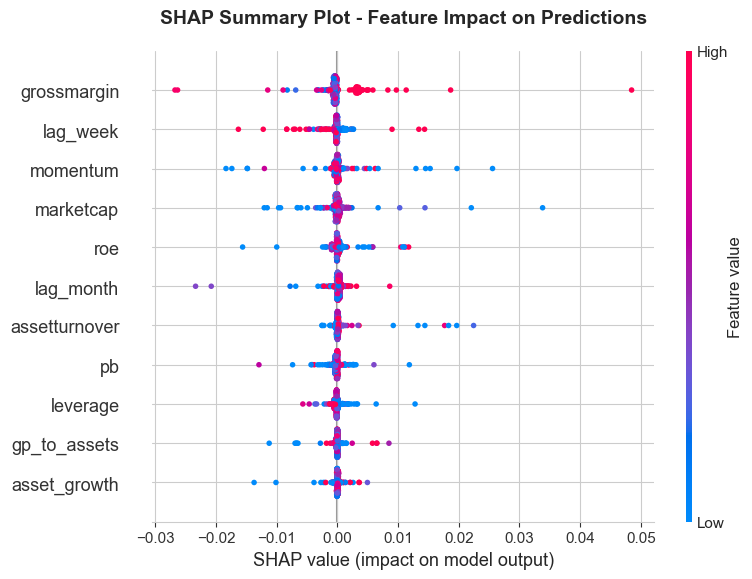

In [8]:
# Summary plot - shows feature importance and impact direction
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

**Interpretation:**
- Each point represents a stock
- Color indicates feature value (red=high, blue=low)
- Position shows SHAP value (impact on prediction)
- Features are ordered by importance (top=most important)

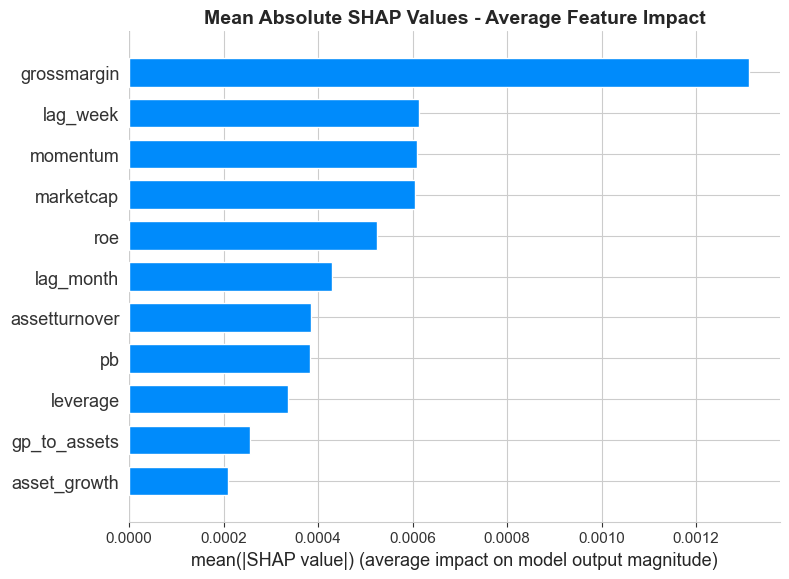

In [9]:
# Bar plot showing mean absolute SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, 
                  plot_type="bar", show=False)
plt.title('Mean Absolute SHAP Values - Average Feature Impact', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Explain Specific Predictions

Let's analyze the top predicted stocks to understand what drives high predictions.

In [10]:
# Get top 5 and bottom 5 stocks
top_stocks = df.nlargest(5, 'predict')
bottom_stocks = df.nsmallest(5, 'predict')

print("TOP 5 PREDICTED STOCKS:")
print("="*80)
for idx, row in top_stocks.iterrows():
    print(f"\n{row['ticker']} - Predicted Return: {row['predict']*100:.2f}%")
    print(f"  Sector: {row['sector']}, Size: {row['size']}")
    print(f"  Momentum: {row['momentum']*100:.2f}%, P/B: {row['pb']:.2f}, ROE: {row['roe']*100:.2f}%")

print("\n" + "="*80)
print("\nBOTTOM 5 PREDICTED STOCKS:")
print("="*80)
for idx, row in bottom_stocks.iterrows():
    print(f"\n{row['ticker']} - Predicted Return: {row['predict']*100:.2f}%")
    print(f"  Sector: {row['sector']}, Size: {row['size']}")
    print(f"  Momentum: {row['momentum']*100:.2f}%, P/B: {row['pb']:.2f}, ROE: {row['roe']*100:.2f}%")

TOP 5 PREDICTED STOCKS:

IMA - Predicted Return: 15.68%
  Sector: Healthcare, Size: Micro-Cap
  Momentum: -61.46%, P/B: 0.60, ROE: -35.30%

CKX - Predicted Return: 14.82%
  Sector: Energy, Size: Micro-Cap
  Momentum: -11.89%, P/B: 1.10, ROE: 1.40%

SMLR - Predicted Return: 14.14%
  Sector: Healthcare, Size: Small-Cap
  Momentum: -57.98%, P/B: 0.60, ROE: 34.60%

MOVE - Predicted Return: 11.37%
  Sector: Healthcare, Size: Micro-Cap
  Momentum: -87.71%, P/B: -5.20, ROE: -288.40%

LYEL - Predicted Return: 7.88%
  Sector: Healthcare, Size: Small-Cap
  Momentum: -6.68%, P/B: 1.20, ROE: -65.90%


BOTTOM 5 PREDICTED STOCKS:

ENVB - Predicted Return: -13.70%
  Sector: Healthcare, Size: Nano-Cap
  Momentum: -87.32%, P/B: 1.00, ROE: -219.70%

SBDS - Predicted Return: -11.03%
  Sector: Consumer Cyclical, Size: Micro-Cap
  Momentum: -70.97%, P/B: 0.20, ROE: -58.40%

OESX - Predicted Return: -10.04%
  Sector: Industrials, Size: Micro-Cap
  Momentum: 12.88%, P/B: 4.60, ROE: -77.10%

FLGC - Predicted 


Explaining prediction for IMA (Top prediction)


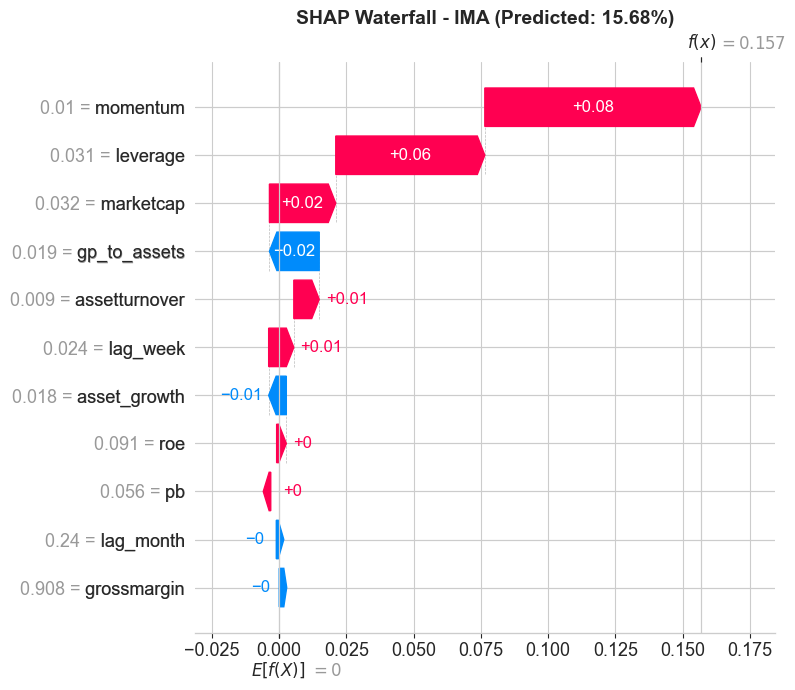

In [11]:
# Calculate SHAP values for top stocks
top_indices = top_stocks.index.tolist()
X_top = X[top_indices]
shap_values_top = explainer.shap_values(X_top)

# Waterfall plot for the #1 predicted stock
print(f"\nExplaining prediction for {top_stocks.iloc[0]['ticker']} (Top prediction)")
shap.waterfall_plot(
    shap.Explanation(values=shap_values_top[0], 
                     base_values=explainer.expected_value,
                     data=X_top[0],
                     feature_names=feature_cols),
    max_display=12,
    show=False
)
plt.title(f"SHAP Waterfall - {top_stocks.iloc[0]['ticker']} (Predicted: {top_stocks.iloc[0]['predict']*100:.2f}%)", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Waterfall Plot Interpretation:**
- Starts at the base value (average prediction across all stocks)
- Each feature pushes the prediction up (red) or down (blue)
- The final value is the actual prediction for this stock

In [12]:
# Force plot for top 3 stocks
print("\nForce plots for top 3 predictions:")
print("(Shows how each feature contributes to pushing prediction above/below base value)\n")

shap.initjs()

for i in range(min(3, len(top_stocks))):
    ticker = top_stocks.iloc[i]['ticker']
    prediction = top_stocks.iloc[i]['predict']
    print(f"\n{i+1}. {ticker} - Predicted: {prediction*100:.2f}%")
    
    display(shap.force_plot(
        explainer.expected_value,
        shap_values_top[i],
        X_top[i],
        feature_names=feature_cols,
        matplotlib=False
    ))


Force plots for top 3 predictions:
(Shows how each feature contributes to pushing prediction above/below base value)




1. IMA - Predicted: 15.68%



2. CKX - Predicted: 14.82%



3. SMLR - Predicted: 14.14%


## 6. Compare Top vs Bottom Predictions

Let's compare the feature distributions between high and low predicted stocks.

In [13]:
# Define top and bottom deciles
df['decile'] = pd.qcut(df['predict'], q=10, labels=range(1, 11))
top_decile = df[df['decile'] == 10].copy()
bottom_decile = df[df['decile'] == 1].copy()

print(f"Top decile (D10): {len(top_decile)} stocks")
print(f"Bottom decile (D1): {len(bottom_decile)} stocks")

# Compare key features
comparison_features = ['momentum', 'lag_week', 'lag_month', 'pb', 'roe', 
                       'asset_growth', 'grossmargin', 'leverage']

comparison = pd.DataFrame({
    'Feature': comparison_features,
    'Top_Decile_Mean': [top_decile[f].mean() for f in comparison_features],
    'Bottom_Decile_Mean': [bottom_decile[f].mean() for f in comparison_features],
})
comparison['Difference'] = comparison['Top_Decile_Mean'] - comparison['Bottom_Decile_Mean']

print("\nFeature Comparison: Top Decile vs Bottom Decile")
print(comparison.to_string(index=False))

ValueError: Bin edges must be unique: Index([   -0.1369959298636247, -0.0007063631871390409, -0.0004924781770069494,
       -0.0002177022199545803, -0.0001787420273086923, -0.0001787420273086923,
        6.052557222036359e-05,  0.0004649338067238908,   0.001501605286344766,
          0.00211115658342831,     0.1568139177485973],
      dtype='float64', name='predict').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(comparison_features[:9]):
    ax = axes[i]
    
    # Plot distributions
    ax.hist(bottom_decile[feature], bins=30, alpha=0.5, label='Bottom Decile (D1)', color='red')
    ax.hist(top_decile[feature], bins=30, alpha=0.5, label='Top Decile (D10)', color='green')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_title(f'{feature}', fontweight='bold')

plt.suptitle('Feature Distributions: Top vs Bottom Decile', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Feature Interaction Analysis

Let's examine how features interact with each other.

In [ ]:
# Plot prediction vs key features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

key_features = ['momentum', 'lag_week', 'pb', 'roe', 'asset_growth', 'grossmargin']

for i, feature in enumerate(key_features):
    ax = axes[i]
    
    # Scatter plot with trend line
    ax.scatter(df[feature], df['predict'], alpha=0.3, s=10)
    
    # Add trend line
    z = np.polyfit(df[feature], df['predict'], 1)
    p = np.poly1d(z)
    ax.plot(df[feature], p(df[feature]), "r--", linewidth=2, label='Trend')
    
    ax.set_xlabel(feature, fontweight='bold')
    ax.set_ylabel('Predicted Return', fontweight='bold')
    ax.set_title(f'Prediction vs {feature}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature Relationships with Predictions', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 8. SHAP Dependence Plots

Shows how a single feature affects predictions, accounting for interactions.

In [ ]:
# Get top 3 most important features
top_3_features = importance['feature'].head(3).tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_3_features):
    feature_idx = feature_cols.index(feature)
    
    plt.sca(axes[i])
    shap.dependence_plot(
        feature_idx,
        shap_values,
        X_sample,
        feature_names=feature_cols,
        show=False
    )
    axes[i].set_title(f'SHAP Dependence: {feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Dependence Plot Interpretation:**
- X-axis: Feature value (percentile rank)
- Y-axis: SHAP value (impact on prediction)
- Color: Interaction with another feature
- Shows non-linear relationships and interactions

## 9. Sector and Size Analysis

Let's see if certain sectors or size groups have systematically different predictions.

In [ ]:
# Predictions by sector
sector_stats = df.groupby('sector')['predict'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
sector_stats.columns = ['Mean Prediction', 'Median Prediction', 'Count']

print("Predictions by Sector:")
print(sector_stats)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sector
sector_stats['Mean Prediction'].plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Mean Predicted Return', fontweight='bold')
ax1.set_title('Average Prediction by Sector', fontsize=14, fontweight='bold')
ax1.axvline(x=df['predict'].mean(), color='red', linestyle='--', label='Overall Mean')
ax1.legend()

# Size
size_stats = df.groupby('size')['predict'].mean().sort_values(ascending=False)
size_stats.plot(kind='barh', ax=ax2, color='coral')
ax2.set_xlabel('Mean Predicted Return', fontweight='bold')
ax2.set_title('Average Prediction by Size', fontsize=14, fontweight='bold')
ax2.axvline(x=df['predict'].mean(), color='red', linestyle='--', label='Overall Mean')
ax2.legend()

plt.tight_layout()
plt.show()

## 10. Summary and Key Insights

In [ ]:
print("="*80)
print("KEY INSIGHTS FROM MODEL EXPLAINABILITY ANALYSIS")
print("="*80)

print("\n1. MOST IMPORTANT FEATURES (by model):")
for i, row in importance.head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.1f}")

print("\n2. TOP PREDICTED STOCKS:")
for i, row in top_stocks.head(3).iterrows():
    print(f"   {row['ticker']}: {row['predict']*100:.2f}% - {row['sector']}, {row['size']}")

print("\n3. FEATURE CHARACTERISTICS OF TOP DECILE:")
top_characteristics = comparison.nlargest(3, 'Difference')
for i, row in top_characteristics.iterrows():
    direction = "higher" if row['Difference'] > 0 else "lower"
    print(f"   {row['Feature']}: {direction} by {abs(row['Difference']):.4f}")

print("\n4. PREDICTION DISTRIBUTION:")
print(f"   Mean: {df['predict'].mean()*100:.2f}%")
print(f"   Median: {df['predict'].median()*100:.2f}%")
print(f"   Std Dev: {df['predict'].std()*100:.2f}%")
print(f"   Range: {df['predict'].min()*100:.2f}% to {df['predict'].max()*100:.2f}%")

print("\n5. BEST PERFORMING SECTORS (by average prediction):")
for sector, mean_pred in sector_stats.head(3)['Mean Prediction'].items():
    print(f"   {sector}: {mean_pred*100:.2f}%")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("""
The model's predictions are primarily driven by:
- Recent momentum and past returns (lag_week, lag_month, momentum)
- Valuation metrics (P/B ratio, ROE)
- Growth indicators (asset_growth, margins)

Stocks with high predicted returns typically exhibit:
- Strong recent momentum
- Favorable valuation characteristics
- Better profitability metrics

The SHAP analysis reveals that the model uses non-linear relationships
and interactions between features, which helps explain why simple
correlations don't fully capture the prediction logic.
""")

print("="*80)

## 11. Export Detailed Analysis

In [ ]:
# Create detailed export with SHAP values for top/bottom stocks
# Calculate SHAP for top and bottom 20
top_20 = df.nlargest(20, 'predict')
bottom_20 = df.nsmallest(20, 'predict')
analysis_stocks = pd.concat([top_20, bottom_20])

X_analysis = X[analysis_stocks.index]
shap_values_analysis = explainer.shap_values(X_analysis)

# Create DataFrame with SHAP contributions
shap_df = pd.DataFrame(shap_values_analysis, columns=[f'shap_{col}' for col in feature_cols])
shap_df.index = analysis_stocks.index

# Combine with original data
export_df = pd.concat([analysis_stocks, shap_df], axis=1)
export_df['base_value'] = explainer.expected_value

# Save to Excel
export_df.to_excel('model_explanation_details.xlsx', index=False)
print("\nDetailed analysis exported to: model_explanation_details.xlsx")
print(f"Includes {len(export_df)} stocks with SHAP value breakdowns")